In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import BertForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import BertTokenizer
from datasets import load_dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/home/andreisemenov/anaconda3/envs/secondord/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-30 15:40:11.685268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 15:40:11.704652: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 15:40:11.710539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 15:40:11.736824: I tensorflow/core/platform/cpu_feature_guard.cc:210] This 

In [2]:
import wget
import os
print('Downloading dataset')
# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url, './cola_public_1.1.zip')
  if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [3]:
import pandas as pd
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t',
                 header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
# print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.
...,...,...,...,...
8546,ad03,0,*,Poseidon appears to own a dragon
8547,ad03,0,*,Digitize is my happiest memory
8548,ad03,1,NaN,It is easy to slay the Gorgon.
8549,ad03,1,NaN,I had the strangest feeling that I knew you.


In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import bisect

import scipy
from scipy import stats

import numpy as np


def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred)).contiguous()
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def smooth(a, eps=0.01):
    b = [a[0]]
    for e in a[1:]:
        b.append(b[-1] * (1 - eps) + e * eps)
    return b


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_device(device_no: int):
    if torch.cuda.is_available():
        device = torch.device(f"cuda:{device_no}")
        print("There are %d GPU(s) available." % torch.cuda.device_count())
        print("We will use the GPU:", torch.cuda.get_device_name(device_no))
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")

    return device


def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [6]:
def make_metrics_plot(ax, hist, eps=0.01, alpha=0.5, make_train=True, make_val=True, starting_epoch=0, metric_name="acc_top_1", title="top-1 accuracy"):
    if len(hist) < 7:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    else:
        cmap = plt.get_cmap('hsv')
        colors = cmap(np.linspace(0, 0.9, len(hist)))

    for i, one_optim_hist in enumerate(hist):
        label = one_optim_hist["name"]

        if len(one_optim_hist["train_x"]) == 0:
            continue

        epochs_x = one_optim_hist["epochs_x"][starting_epoch:]
        start = int(epochs_x[0])

        if make_train:
            train_acc_top = one_optim_hist["train_{}".format(metric_name)]
            smoothed_train_acc_top = smooth(train_acc_top, eps=eps)[start:]
            train_x = one_optim_hist["train_x"][start:]
            ax.plot(
                train_x, smoothed_train_acc_top, 
                label=label + " (train)", 
                alpha=alpha, color=colors[i], linestyle="-"
            )

        if make_val and len(one_optim_hist["val_x"]) > 0:
            val_acc_top = one_optim_hist["val_{}".format(metric_name)]
            val_x = one_optim_hist["val_x"]
            ind = bisect.bisect_left(val_x, start)
            ax.plot(
                val_x[ind:], val_acc_top[ind:], 
                label=label + " (val)", 
                alpha=alpha, color=colors[i], linestyle="--"
            )

        #epoch sep lines
        for x in epochs_x:
            ax.axvline(x, linestyle="--", color=colors[i], alpha=0.2)


    if make_train and make_val:
        ax.set_title("{} on train/val".format(title))
    elif make_train:
        ax.set_title("{} on train".format(title))
    elif make_val:
        ax.set_title("{} on val".format(title))
    
    ax.set_ylabel("{}".format(title))
    ax.set_xlabel("Iteration")
    ax.grid(True)

    return ax


In [7]:
def make_accuracy_plot(ax, hist, eps=0.01, alpha=0.5, top_k=1, make_train=True, make_val=True, starting_epoch=0):
    return make_metrics_plot(ax, hist, eps, alpha, make_train, make_val, starting_epoch, metric_name="acc_top_{}".format(top_k), title="top-{} accuracy".format(top_k))


def make_plot(
    ax, hist, y_name, x_name, 
    title="logloss with different optimizers", y_label="logloss", x_label="iteration", 
    eps=0.01, alpha=0.5, starting_epoch=0, draw_epoch_lines=True, grid=True, legend=True,
    mark_every_count=15, title_fontsize=14, xy_label_fontsize=10,
    line_params={}
):
    if len(hist) < 7:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    else:
        cmap = plt.get_cmap('hsv')
        colors = cmap(np.linspace(0, 0.9, len(hist)))

    for i, one_optim_hist in enumerate(hist):
        label = one_optim_hist["name"]
        if label in line_params:
            line_style = line_params[label]["line_style"]
            line_color = line_params[label]["line_color"]
            line_marker = line_params[label]["line_marker"]
            mark_every = line_params[label]["mark_every"]
            label = line_params[label]["name"]
        else:
            line_style="-"
            line_color=colors[i]
            line_marker = None
            mark_every = None

        if len(one_optim_hist["epochs_x"]) <= starting_epoch:
            continue

        epochs_x = one_optim_hist["epochs_x"][starting_epoch:]
        start = int(epochs_x[0])

        if len(one_optim_hist[y_name]) == 0:
            continue

        smoothed_y = smooth(one_optim_hist[y_name], eps=eps)
        x = one_optim_hist[x_name]
        
        ind = bisect.bisect_left(x, start)
        smoothed_y = smoothed_y[ind:]
        x = x[ind:]

        if mark_every == "auto":
            mark_every = len(x) // (mark_every_count + 1)
            mark_every = np.arange((i * mark_every) // (len(hist)), len(x), mark_every)

        ax.plot(
            x, smoothed_y, 
            label=label, alpha=alpha, color=line_color, linestyle=line_style,
            marker=line_marker, markevery=mark_every
        )

        #epoch sep lines
        if draw_epoch_lines:
            for x in epochs_x:
                ax.axvline(x, linestyle="--", color=line_color, alpha=0.2)
    
    plt.rc('font', size=xy_label_fontsize)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_ylabel(y_label, fontsize=xy_label_fontsize)
    ax.set_xlabel(x_label, fontsize=xy_label_fontsize)
    ax.grid(grid)
    if legend:
        ax.legend()

    return ax

def draw_norm_hists_for_different_models(fig, subplotspec_outer, hist, bins_n=100, draw_normal=True, number=-1):
    h = (len(hist) + 2) // 3
    sgs = subplotspec_outer.subgridspec(h, 3, wspace=0.15, hspace=0.25)
    for (i, one_optim_hist) in enumerate(hist):
        ax = fig.add_subplot(sgs[i // 3, i % 3])
        if len(one_optim_hist["norm_diffs"]) > 0:
            ax = draw_norm_hist(ax, one_optim_hist["norm_diffs"][number], bins_n=bins_n, draw_normal=draw_normal)
            label = one_optim_hist["name"]
            ax.set_title("{},\n batch_count={}, skew={:0.2f}".format(
                label, 
                len(one_optim_hist["norm_diffs"][number]), 
                stats.skew(one_optim_hist["norm_diffs"][number])
            ), fontsize=11)
        ax.set_ylabel("Density")
        ax.set_xlabel("Noise norm")
        ax.grid(True)

    ax = plt.Subplot(fig, subplotspec_outer)
    ax.set_title("Distribution of the gradient noise for different optimizers", y=1.15, fontsize=14)
    ax.set_frame_on(False)
    ax.axis('off')
    fig.add_subplot(ax)

    return ax

In [8]:
import scipy
from scipy import stats
from tqdm.notebook import tqdm

def get_batch_grad(model):
    gr=[]
    for i in model.parameters():
        if i.requires_grad:
            gr.append(i.grad.view(-1))
    return torch.cat(gr)


def get_loss(model, criterion, batch):
    inputs, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    return loss

def compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad):
    fully_grad = []
    optimizer.zero_grad()

    print("Computing full gradient")
    with tqdm(total=len(dataloader_for_full_grad)) as pbar:
        for step, batch in enumerate(dataloader_for_full_grad):
            loss = get_loss(model, criterion, batch)
            loss.backward()

            if fully_grad != []:
                fully_grad = fully_grad + get_batch_grad(model) * \
                    dataloader_for_full_grad.batch_size
            else:
                fully_grad = get_batch_grad(model) * dataloader_for_full_grad.batch_size
            optimizer.zero_grad()

            pbar.update(1)

    return fully_grad / (step * dataloader_for_full_grad.batch_size)

def compute_norm_diffs(model, optimizer, criterion, dataloader_for_full_grad, dataloader, full_grad=None, repeats=1):
    if full_grad is None:
        full_grad = compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad)
    mini_norms = []
    optimizer.zero_grad()

    print("Computing norm diffs")
    with tqdm(total=repeats * len(dataloader)) as pbar:
        for _ in range(repeats):
            for step, batch in enumerate(dataloader):
                loss = get_loss(model, criterion, batch)
                loss.backward()

                mini_norms.append((get_batch_grad(model) - full_grad).norm().item())
                optimizer.zero_grad()

                pbar.update(1)

    return np.array(mini_norms)

def group_uniques(hist, one_optim_hist, group_unique, loss_name):
    if not group_unique:
        return one_optim_hist[loss_name]
    else:
        res = [0] * len(one_optim_hist[loss_name])
        unique_name = one_optim_hist["name"]
        k = 0
        for one_optim_hist in hist:
            if one_optim_hist["name"] == unique_name:
                k += 1
                for i, elem in enumerate(one_optim_hist[loss_name]):
                    res[i] += elem
        res = [elem / k for elem in res]
        return res

def group_uniques_full(hist, losses_to_average, verbose=False, group_norm_diffs=False):
    grouped_hist = {}
    unique_tried = {}
    for one_optim_hist in hist:
        unique_tried[one_optim_hist["name"]] = False

    for one_optim_hist in hist:
        label = one_optim_hist["name"]
        if not unique_tried[label]:
            unique_tried[label] = True
            grouped_hist[label] = {
                "hist": deepcopy(one_optim_hist),
                "repeats": {
                    loss_name: [1] * len(one_optim_hist[loss_name])
                    for loss_name in losses_to_average
                },
            }
            if group_norm_diffs:
                grouped_hist[label]["hist"]["norm_diffs"] = [
                    [np.array(x)] for x in grouped_hist[label]["hist"]["norm_diffs"]
                ]
            continue

        for loss_name in losses_to_average:
            losses = one_optim_hist[loss_name]

            for i, loss_elem in enumerate(losses):
                if i < len(grouped_hist[label]["hist"][loss_name]):
                    grouped_hist[label]["hist"][loss_name][i] += loss_elem
                else:
                    grouped_hist[label]["hist"][loss_name].append(loss_elem)

                if i >= len(grouped_hist[label]["repeats"][loss_name]):
                    grouped_hist[label]["repeats"][loss_name].append(0)
                grouped_hist[label]["repeats"][loss_name][i] += 1

        if group_norm_diffs:
            if len(grouped_hist[label]["hist"]["norm_diffs"]) == 0:
                if "norm_diffs_x" in one_optim_hist:
                    grouped_hist[label]["hist"]["norm_diffs_x"] = one_optim_hist[
                        "norm_diffs_x"
                    ]
                grouped_hist[label]["hist"]["norm_diffs"] = [
                    [np.array(x)] for x in one_optim_hist["norm_diffs"]
                ]
            else:
                for x, y in zip(
                    grouped_hist[label]["hist"]["norm_diffs"],
                    one_optim_hist["norm_diffs"],
                ):
                    x.append(np.array(y))

    for key in grouped_hist:
        one_optim_hist = grouped_hist[key]
        if verbose and len(one_optim_hist["repeats"][losses_to_average[0]]) > 0:
            repeats_1 = float(one_optim_hist["repeats"][losses_to_average[0]][0])
            print(
                "Repeats_1 = {}, Name = {}".format(
                    repeats_1, one_optim_hist["hist"]["name"]
                )
            )
        for loss_name in losses_to_average:
            for i in range(len(one_optim_hist["hist"][loss_name])):
                repeats = one_optim_hist["repeats"][loss_name][i]
                one_optim_hist["hist"][loss_name][i] /= repeats

        if group_norm_diffs:
            for i, group in enumerate(one_optim_hist["hist"]["norm_diffs"]):
                means = []
                stds = []
                for j, elem in enumerate(group):
                    means.append(elem.mean())
                    stds.append(elem.std())
                    group[j] = (elem - elem.mean()) / elem.std()
                mean = np.mean(means)
                std = np.mean(stds)
                one_optim_hist["hist"]["norm_diffs"][i] = (
                    np.concatenate(group) * std + mean
                )

    grouped_hist = [grouped_hist[x]["hist"] for x in grouped_hist]

    return grouped_hist

In [9]:
def make_loss_plot(ax, hist, eps=0.01, alpha=0.5, make_train=True, make_val=True, starting_epoch=0, group_unique=False, loss_name="logloss"):
    if len(hist) < 7:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    else:
        cmap = plt.get_cmap('hsv')
        colors = cmap(np.linspace(0, 0.9, len(hist)))
    unique_tried = {}
    for one_optim_hist in hist:
        unique_tried[one_optim_hist["name"]] = False

    for i, one_optim_hist in enumerate(hist):
        label = one_optim_hist["name"]

        if group_unique and unique_tried[label]:
            continue
        unique_tried[label] = True
        
        if len(one_optim_hist["train_x"]) == 0:
            continue

        epochs_x = one_optim_hist["epochs_x"][starting_epoch:]
        start = int(epochs_x[0])

        if make_train:
            train_y = group_uniques(hist, one_optim_hist, group_unique, "train_loss")
            smoothed_train_y = smooth(train_y, eps=eps)[start:]
            train_x = one_optim_hist["train_x"][start:]
            ax.plot(
                train_x, smoothed_train_y, 
                label=label + " (train)", 
                alpha=alpha, color=colors[i], linestyle="-"
            )

        if make_val and len(one_optim_hist["val_x"]) > 0:
            val_y = group_uniques(hist, one_optim_hist, group_unique, "val_loss")
            val_x = one_optim_hist["val_x"]
            ind = bisect.bisect_left(val_x, start)
            ax.plot(
                val_x[ind:], val_y[ind:], 
                label=label + " (val)", 
                alpha=alpha, color=colors[i], linestyle="--"
            )

        #epoch sep lines
        for x in epochs_x:
            ax.axvline(x, linestyle="--", color=colors[i], alpha=0.2)

    if make_train and make_val:
        ax.set_title("{} on train/val with different optimizers".format(loss_name))
    elif make_train:
        ax.set_title("{} on train with different optimizers".format(loss_name))
    elif make_val:
        ax.set_title("{} on val with different optimizers".format(loss_name))
    ax.set_ylabel("{}".format(loss_name))
    ax.set_xlabel("Iteration")
    ax.grid(True)
    ax.legend()

    return ax

In [10]:
from copy import deepcopy
import numpy as np

def get_loss(model, criterion, batch):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    outputs = model(
        b_input_ids,
        token_type_ids=None,
        attention_mask=b_input_mask,
        labels=b_labels
    )

    loss=outputs[0]
    return loss

def recursive_to(param, device):
    # Not sure if there are any global tensors in the state dict
    if isinstance(param, torch.Tensor):
        param.data = param.data.to(device)
        if param._grad is not None:
            param._grad.data = param._grad.data.to(device)
    elif isinstance(param, dict):
        for subparam in param.values():
            recursive_to(subparam, device)
    elif isinstance(param, list):
        for subparam in param:
            recursive_to(subparam, device)

def optimizer_to(optim, device):
    for param_group in optim.param_groups:
        for param in param_group.values():
            # Not sure there are any global tensors in the state dict
            recursive_to(param, device)

In [11]:
print('Loading RoBERTa tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

Loading RoBERTa tokenizer...


In [12]:
input_ids = []
# For every sentence...
for sent in df.sentence.values:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)
# Print sentence 0, now as a list of IDs.
print('Original: ', df.sentence.values[0])
print('Token IDs:', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: [0, 2522, 964, 351, 75, 907, 42, 1966, 6, 905, 1937, 5, 220, 65, 52, 15393, 4, 2]


In [13]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  47


In [14]:
def pad_sequences(seqs, maxlen=None, value=0, padding="post"):
    if maxlen is None:
        raise ValueError("Invalid maxlen: {}".format(maxlen))
    for i in range(len(seqs)):
        add = [value] * max(0, maxlen - len(seqs[i]))
        if padding == "post":
            seqs[i] = seqs[i] + add
        elif padding == "pre":
            seqs[i] = add + seqs[i]
    return seqs

MAX_LEN =  max([len(sen) for sen in input_ids])+1
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, value=0, padding="post")
print('\Done.')


Padding/truncating all sentences to 48 values...

Padding token: "<pad>", ID: 1
\Done.


In [15]:
attention_masks = []
# For each sentence...
for sent in input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

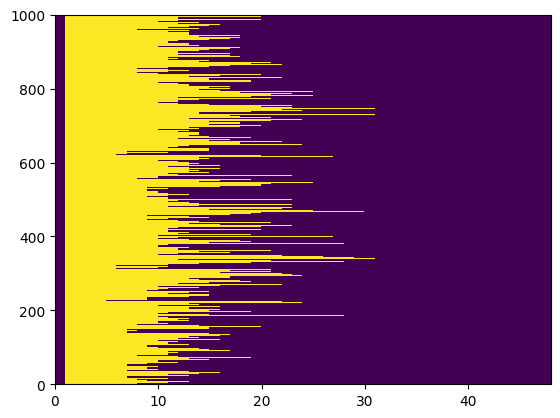

In [16]:
plt.pcolor(attention_masks[1000:2000])

In [17]:
df.label.values

array([1, 1, 1, ..., 1, 1, 1])

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

data_split_rs = 49

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,df.label.values,
                                                            random_state=data_split_rs, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, df.label.values,
                                             random_state=data_split_rs, test_size=0.1)

In [19]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [20]:
device = set_device(2)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


In [21]:
random_seed = 4
num_workers = 1

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
###full_grad_dataloader
batch_size = 32 # train_inputs.shape[0]
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_loader_for_full_grad = DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers,
    worker_init_fn = lambda id: np.random.seed(id + num_workers * random_seed)
)


### for training
batch_size = 32 # train_inputs.shape[0]
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers,
    worker_init_fn = lambda id: np.random.seed(id + num_workers * random_seed)
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
val_loader = DataLoader(
    validation_data, batch_size=batch_size, shuffle=True, num_workers=num_workers,
    worker_init_fn = lambda id: np.random.seed(id + num_workers * random_seed)
)

In [37]:
def compute_fisher_and_hessian_bert(model, inputs, masks, target):
    N = inputs.size(0)
    device = next(model.parameters()).device
    num_params = sum(p.numel() for p in model.classifier.out_proj.parameters())
    fisher_matrix = torch.zeros(num_params, num_params).to(device)
    hessian_matrix = torch.zeros(num_params, num_params).to(device)

    model.zero_grad()

    output = model(
                inputs,
                token_type_ids=None,
                attention_mask=masks,
                labels=target
    )
    loss = output[0]

    grads = torch.autograd.grad(loss, model.classifier.out_proj.parameters(), create_graph=True)[0]
    grad = torch.cat([g.view(-1) for g in grads])

    fisher_matrix += grad.unsqueeze(1) @ grad.unsqueeze(0)

    for j in range(num_params):
        grad_grad = torch.autograd.grad(grad[j], model.classifier.out_proj.parameters(), retain_graph=True)
        hessian_matrix[j] += torch.cat([g.contiguous().view(-1) for g in grad_grad])

    fisher_matrix /= N
    hessian_matrix /= N

    return grads, fisher_matrix, hessian_matrix

In [23]:
def create_hist(opt_name: str = "Adam, 5e-5, eps 1e-8, weight_decay 0.0005, bs_mul = 1"):
    hist = []
    bs_mul = 1
    opt_name = opt_name
    hist.append({
        "task_name": "BERT on CoLA",
        "name": opt_name,
        "bs_mul": bs_mul,
        #"lr_decay": lr_decay,
        "train_loss": [], "train_x": [],
        "val_loss": [], "val_x": [],
        "train_acc_top_1": [], "train_acc_top_5": [],
        "val_acc_top_1": [], "val_acc_top_5": [],
        "norm_diffs": [],
        "epochs_x": [],
        "norm_diffs_x": [],
        "total_steps": 0,
        "prev_val_eval_step": 0,
        "prev_grad_norms_eval_step": 0,
        "batch_end": True
    })
    return hist

In [28]:
hist = create_hist("Adam, 1e-3, eps 1e-8, weight_decay 0.0005, bs_mul = 1")

net = RobertaForSequenceClassification.from_pretrained(
                "roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
                num_labels = 2, # The number of output labels--2 for binary classification.
                                # You can increase this for multi-class tasks.
                output_attentions = False, # Whether the model returns attentions weights.
                output_hidden_states = False, # Whether the model returns all hidden-states.
            )

net.zero_grad()
for i, name_param in enumerate(net.named_parameters()):
    if 'classifier' not in name_param[0]:
        name_param[1].requires_grad = False
net.classifier.out_proj.bias = None
net.train()

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3, eps = 1e-8, weight_decay=0.0005)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


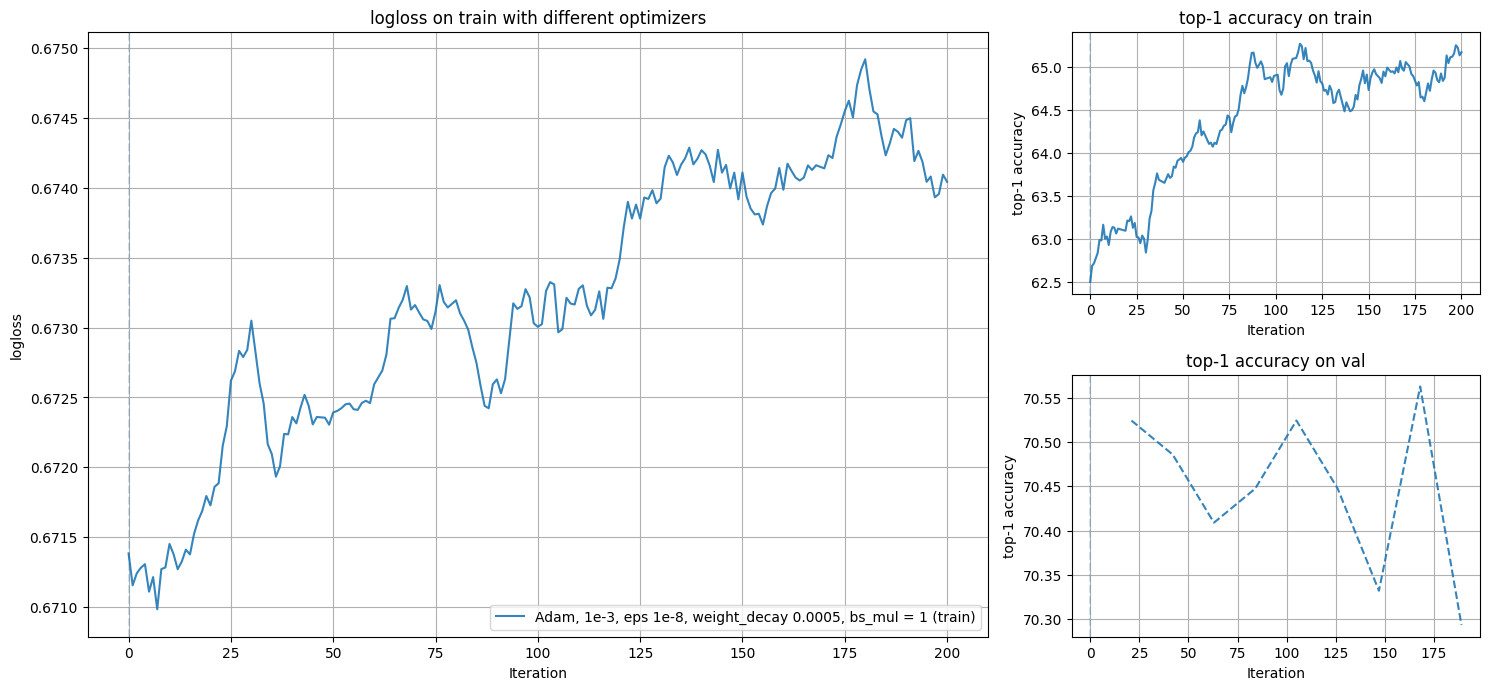

Finished Training


In [27]:
from IPython import display

batch_mul_step_count = 400
calc_norm_diffs = False
grad_norms = []
hess_norms_diff = []

num_epochs = 1
for epoch in range(num_epochs):
    for net_hist in hist:
        net.to(device)
        optimizer_to(optimizer, device)

        total_steps = net_hist["total_steps"]
        # effective batch size will be batch_size * bs_mul
        bs_mul = net_hist["bs_mul"]
        # learning rate decay rate
        #lr_decay = net_hist["lr_decay"]

        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]

        net_hist["epochs_x"].append(total_steps)

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # compute norm diffs distribution on train dataset
            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > 500 or len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer, None,
                    train_loader_for_full_grad, train_loader, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False
            ######################################################################
            #if lr_decay < 1:
            #    for g in optimizer.param_groups:
            #        g['lr'] = g['lr'] * lr_decay
            ######################################################################
            # train
            inputs, masks, labels = data[0].to(device), data[1].to(device), data[2].to(device)

            outputs = net(
                inputs,
                token_type_ids=None,
                attention_mask=masks,
                labels=labels
            )
            loss = outputs[0] / bs_mul
            loss.backward()
            grads, fisher, hessian = compute_fisher_and_hessian_bert(net, inputs, masks, labels)
            grad_norms.append(torch.norm(grads, p=2).detach().item())
            hess_norms_diff.append(torch.norm(fisher - hessian, p=2).detach().item())


            if total_steps % bs_mul == bs_mul - 1:
                optimizer.step()
                optimizer.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1
                    bs_mul = net_hist["bs_mul_value"]

            top_1 = accuracy(outputs.logits, labels.data, topk=(1,))
            net_hist["train_acc_top_1"].append(top_1[0].detach().cpu().item())

                # evaluate on validation dataset
            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > 20 and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_losses = []
                val_accs = []

                with torch.no_grad():
                    for step, val_data in enumerate(val_loader):

                        inputs, masks, labels = val_data[0].to(device), val_data[1].to(device), val_data[2].to(device)

                        outputs = net(
                            inputs,
                            token_type_ids=None,
                            attention_mask=masks,
                            labels=labels
                        )
                        loss = outputs[0]

                        val_losses.append(loss.detach().cpu().item())

                        acc = accuracy(outputs.logits, labels.data, topk=(1,))
                        val_accs.append(acc[0].detach().cpu().item())

                net_hist["val_loss"].append(np.mean(val_losses))
                net_hist["val_x"].append(total_steps)

                net_hist["val_acc_top_1"].append(np.mean(val_accs))

                net.train()

            if total_steps % 100 == 0:
                display.clear_output(wait=True)

                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(ax1, grouped_hist, eps=0.01, make_val=False, alpha=0.9)
                ax2 = make_accuracy_plot(ax2, grouped_hist, eps=0.01, make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(ax3, grouped_hist, eps=0.01, make_train=False, make_val=True, top_k=1, alpha=0.9)

                if calc_norm_diffs == True:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
        net.to("cpu")
        optimizer_to(optimizer, "cpu")

print('Finished Training')


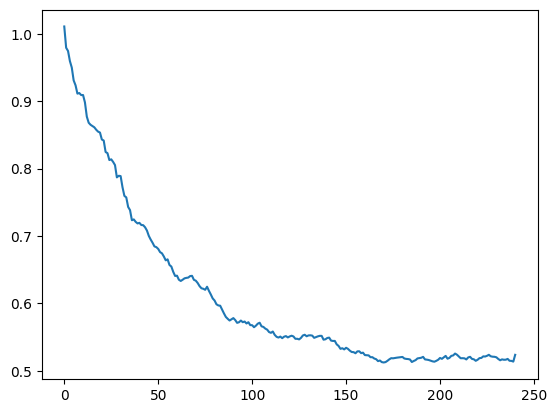

In [33]:
plt.plot(np.array(smooth(hess_norms_diff)) / np.sqrt(smooth(grad_norms)))
plt.show()

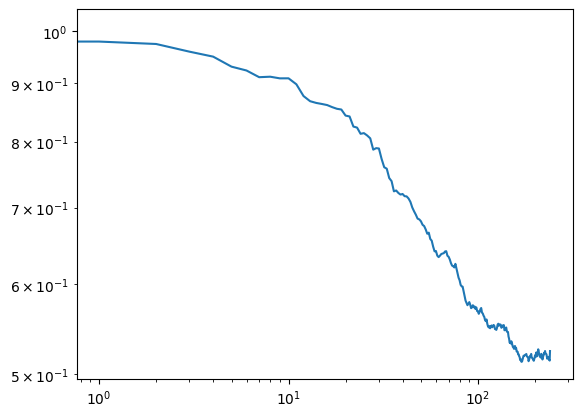

In [34]:
plt.loglog(np.array(smooth(hess_norms_diff)) / np.sqrt(smooth(grad_norms)))
plt.show()

LONG RUN

In [41]:
num_runs = 5
all_grad_norms_roberta = []
all_hess_norms_diff_roberta = []

In [42]:
torch.cuda.empty_cache()

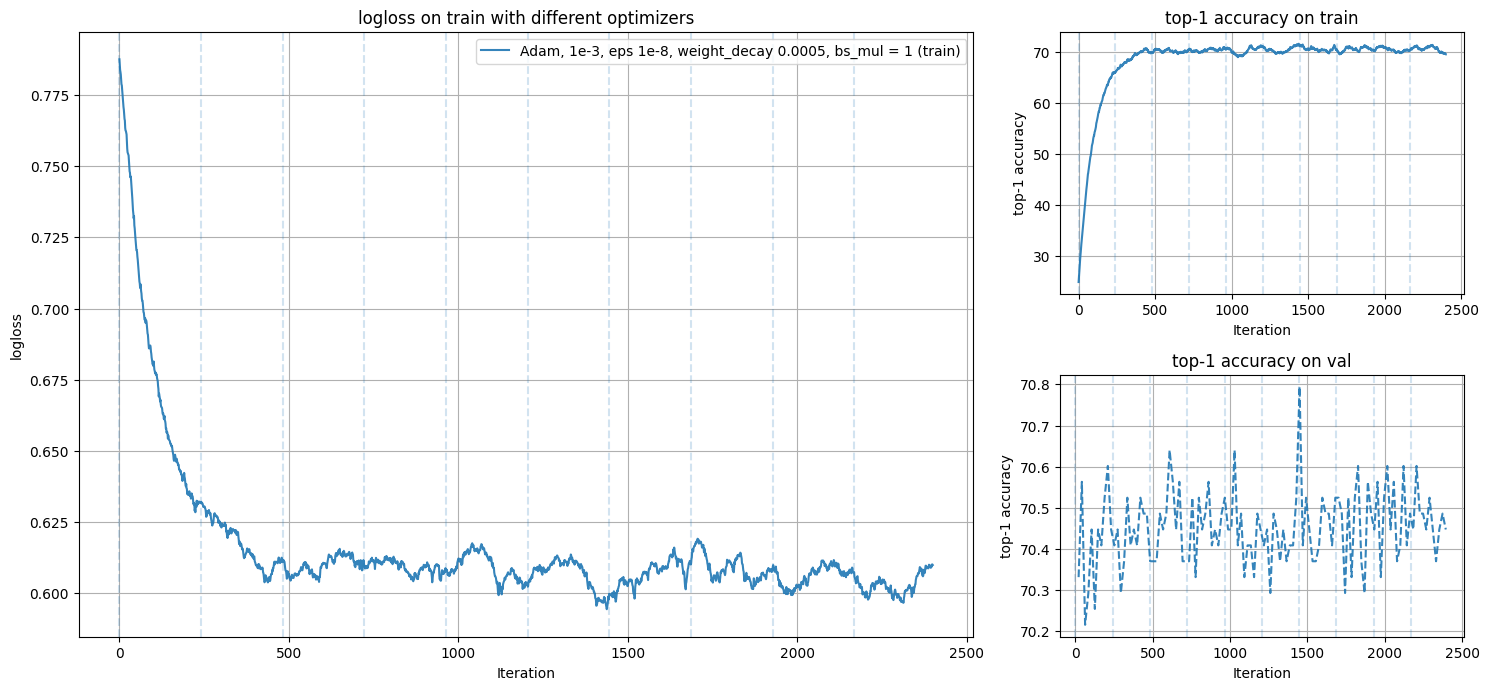

Finished run 5/5
CPU times: user 9h 27min 59s, sys: 49min 7s, total: 10h 17min 7s
Wall time: 4h 46min 25s


In [43]:
%%time
from IPython import display

for run in range(num_runs):
    print(f"Starting run {run + 1}/{num_runs}")
    
    hist = create_hist("Adam, 1e-3, eps 1e-8, weight_decay 0.0005, bs_mul = 1")

    net = RobertaForSequenceClassification.from_pretrained(
                    "roberta-base",
                    num_labels = 2,
                    output_attentions = False,
                    output_hidden_states = False,
                )

    net.zero_grad()
    for i, name_param in enumerate(net.named_parameters()):
        if 'classifier' not in name_param[0]:
            name_param[1].requires_grad = False
    net.classifier.out_proj.bias = None
    net.train()

    optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3, eps = 1e-8, weight_decay=0.0005)
    batch_mul_step_count = 400
    calc_norm_diffs = False
    grad_norms = []
    hess_norms_diff = []

    num_epochs = 10
    for epoch in range(num_epochs):
        for net_hist in hist:
            net.to(device)
            optimizer_to(optimizer, device)

            total_steps = net_hist["total_steps"]
            # effective batch size will be batch_size * bs_mul
            bs_mul = net_hist["bs_mul"]
            # learning rate decay rate
            #lr_decay = net_hist["lr_decay"]

            if net_hist["bs_mul"] == "linear":
                if not ("bs_mul_value" in net_hist):
                    net_hist["bs_mul_value"] = 1

                bs_mul = net_hist["bs_mul_value"]

            net_hist["epochs_x"].append(total_steps)

            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                # compute norm diffs distribution on train dataset
                prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
                if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > 500 or len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                    net_hist["prev_grad_norms_eval_step"] = total_steps
                    net.eval()

                    norm_diffs = compute_norm_diffs(
                        net, optimizer, None,
                        train_loader_for_full_grad, train_loader, repeats=5
                    )

                    net_hist["norm_diffs"].append(norm_diffs)
                    net_hist["norm_diffs_x"].append(total_steps)
                    net.train()

                net_hist["batch_end"] = False
                ######################################################################
                #if lr_decay < 1:
                #    for g in optimizer.param_groups:
                #        g['lr'] = g['lr'] * lr_decay
                ######################################################################
                # train
                inputs, masks, labels = data[0].to(device), data[1].to(device), data[2].to(device)

                outputs = net(
                    inputs,
                    token_type_ids=None,
                    attention_mask=masks,
                    labels=labels
                )
                loss = outputs[0] / bs_mul
                loss.backward()


                if total_steps % bs_mul == bs_mul - 1:
                    optimizer.step()
                    optimizer.zero_grad()
                    net_hist["batch_end"] = True

                grads, fisher, hessian = compute_fisher_and_hessian_bert(net, inputs, masks, labels)
                grad_norms.append(torch.norm(grads, p=2).detach().item())
                hess_norms_diff.append(torch.norm(fisher - hessian, p=2).detach().item())
                net_hist["train_loss"].append(loss.detach().cpu().item() * bs_mul)
                net_hist["train_x"].append(total_steps)

                if total_steps % bs_mul == bs_mul - 1:
                    if net_hist["bs_mul"] == "linear":
                        net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1
                        bs_mul = net_hist["bs_mul_value"]

                top_1 = accuracy(outputs.logits, labels.data, topk=(1,))
                net_hist["train_acc_top_1"].append(top_1[0].detach().cpu().item())

                    # evaluate on validation dataset
                prev_val_eval_step = net_hist["prev_val_eval_step"]
                if (total_steps - prev_val_eval_step) > 20 and net_hist["batch_end"]:
                    net_hist["prev_val_eval_step"] = total_steps

                    net.eval()

                    val_losses = []
                    val_accs = []

                    with torch.no_grad():
                        for step, val_data in enumerate(val_loader):

                            inputs, masks, labels = val_data[0].to(device), val_data[1].to(device), val_data[2].to(device)

                            outputs = net(
                                inputs,
                                token_type_ids=None,
                                attention_mask=masks,
                                labels=labels
                            )
                            loss = outputs[0]

                            val_losses.append(loss.detach().cpu().item())

                            acc = accuracy(outputs.logits, labels.data, topk=(1,))
                            val_accs.append(acc[0].detach().cpu().item())

                    net_hist["val_loss"].append(np.mean(val_losses))
                    net_hist["val_x"].append(total_steps)

                    net_hist["val_acc_top_1"].append(np.mean(val_accs))

                    net.train()

                if total_steps % 100 == 0:
                    display.clear_output(wait=True)

                    grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                    fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                    gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                    ax1 = fig.add_subplot(gs[0:4,:2])
                    ax2 = fig.add_subplot(gs[0:2,2])
                    ax3 = fig.add_subplot(gs[2:4,2])

                    ax1 = make_loss_plot(ax1, grouped_hist, eps=0.01, make_val=False, alpha=0.9)
                    ax2 = make_accuracy_plot(ax2, grouped_hist, eps=0.01, make_train=True, make_val=False, top_k=1, alpha=0.9)
                    ax3 = make_accuracy_plot(ax3, grouped_hist, eps=0.01, make_train=False, make_val=True, top_k=1, alpha=0.9)

                    if calc_norm_diffs == True:
                        draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                    gs.tight_layout(fig)
                    plt.draw()
                    plt.show()

                total_steps += 1
            net_hist["total_steps"] = total_steps
            net.to("cpu")
            optimizer_to(optimizer, "cpu")

    print(f"Finished run {run + 1}/{num_runs}")

    all_grad_norms_roberta.append(grad_norms)
    all_hess_norms_diff_roberta.append(hess_norms_diff)

In [44]:
np.save('fisher_roberta_cola_grad_norms.npy', all_grad_norms_roberta)
np.save('fisher_roberta_cola_hess_norms.npy', all_hess_norms_diff_roberta)